# Predicting Diabetes using Machine Learning

The goal of this notebook is to analyze "Pima Indians Diabetes Database" and to predict whether a patient has diabetes or not using supervised machine learning models.


## Data Description

### Context
This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

### Acknowledgements
Smith, J.W., Everhart, J.E., Dickson, W.C., Knowler, W.C., & Johannes, R.S. (1988). Using the ADAP learning algorithm to forecast the onset of diabetes mellitus. In Proceedings of the Symposium on Computer Applications and Medical Care (pp. 261--265). IEEE Computer Society Press.

### About this dataset
The datasets consist of several medical predictor (independent) variables and one target (dependent) variable, Outcome. Independent variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on. For the outcome class value 1 is interpreted as "tested positive for diabetes".

|Column Name| Description|
|:------------|:------------|
|Pregnancies|Number of times pregnant|
|Glucose|Plasma glucose concentration a 2 hours in an oral glucose tolerance test|
|BloodPressure|Diastolic blood pressure (mm Hg)|
|SkinThickness|Triceps skin fold thickness (mm)|
|Insulin|2-Hour serum insulin (mu U/ml)|
|BMI|Body mass index (weight in kg/(height in m)^2)|
|DiabetesPedigreeFunction| Diabetes pedigree function|
|Age| Age (years)|
|Outcome|Class variable (0 or 1) |

## Importing libraries

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, recall_score, precision_score, \
    f1_score, roc_auc_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree

# Set random seed 
RSEED = 7
warnings.filterwarnings("ignore")

## Importing the data

In [40]:
# Load csv file
df = pd.read_csv('data/diabetes.csv')

## Exploratory Data Analysis (EDA)


In [41]:
# Display the first 5 rows
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [42]:
# Display the shape
df.shape

(768, 9)

The data has 9 columns and 768 observations. The first 8 columns are the feature variables and the last column (Outcome) is the target variable.

In [43]:
# Checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [44]:
# Checking the statistics of the data
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


The columns Glucose, BloodPressure, SkinThickness, Insulin and BMI have 0 as the minimum values. These 0 values which do not make sense, since it is not possible to be 0 for these measurable quantities. We replace the zero values in these columns to get a better sense of how much data has missing values.

In [45]:
cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols:
    df[col].replace(0, np.nan, inplace=True)

These are the missing values for each column:

In [46]:
df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

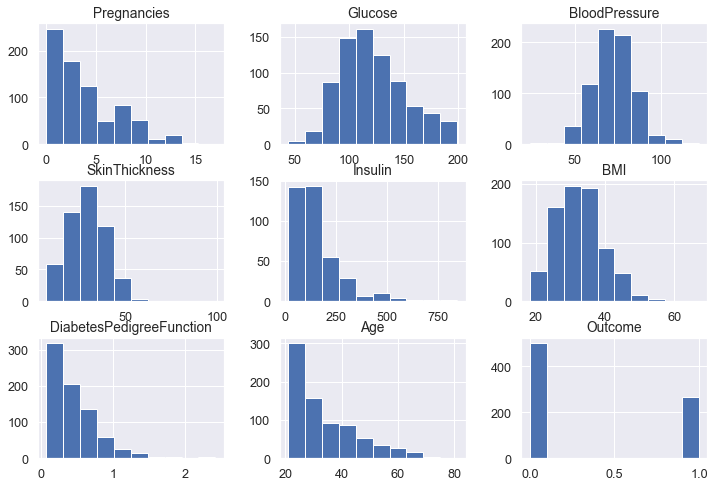

In [47]:
df.hist(figsize=(12,8));

Based on the distribution of Outcome, the target variable is unbalanced. The number of patients without diabetes is approximately twice the number of patients with diabetes.

### Correlation matrix:

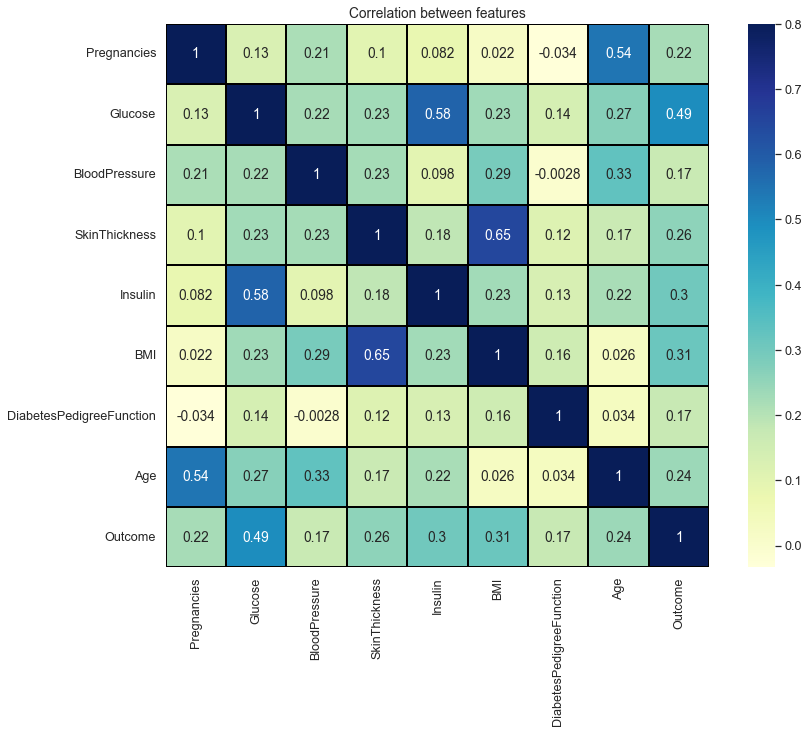

In [48]:
corr=df.corr()
sns.set(font_scale=1.15)
plt.figure(figsize=(14, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="black")
plt.title('Correlation between features');

Based on the histogram of Outcomes, the target variable is unbalanced. The number of patients without diabetes is approximately twice the number of patients with diabetes.

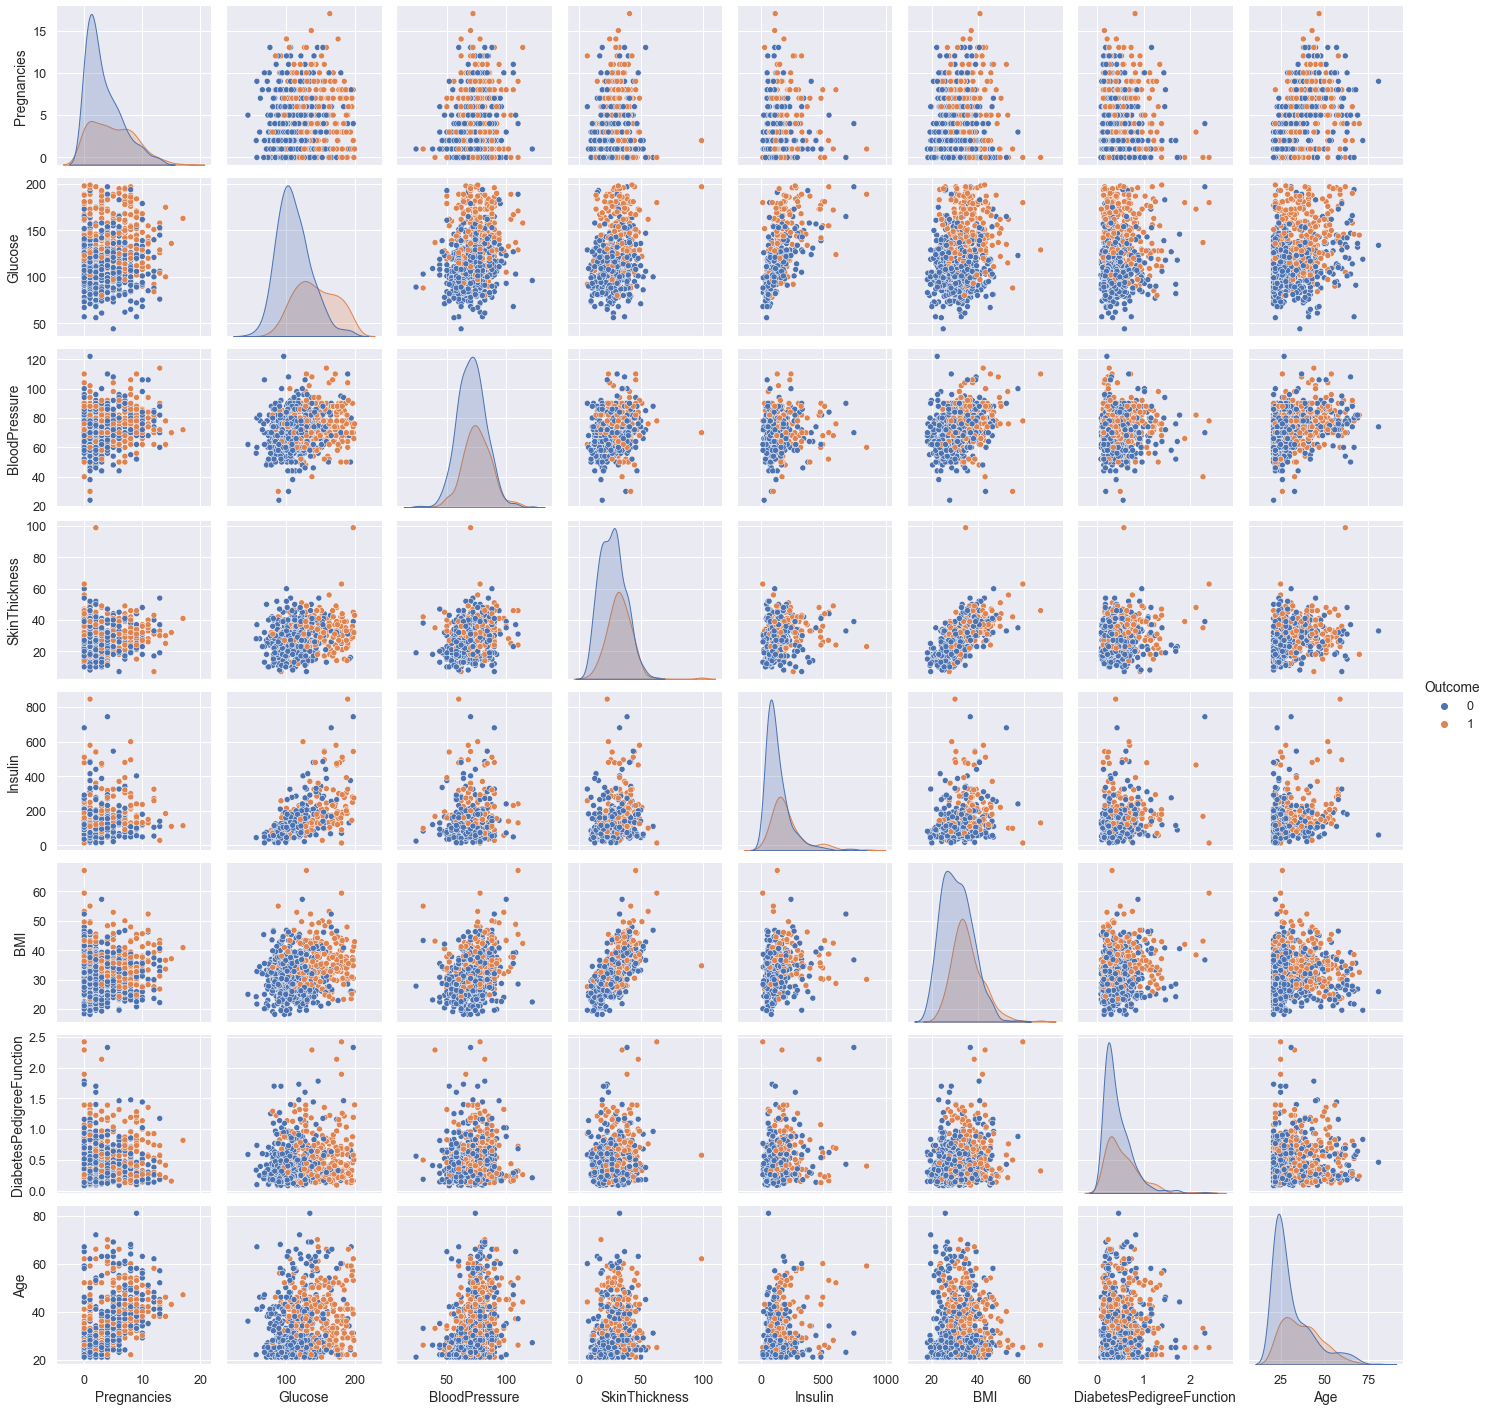

In [49]:
sns.pairplot(df, hue = 'Outcome');

## Preprocessing the data

### Split into train and test data set

The data set is split into training and test sets.

In [50]:
# Define features and target variables
X = df.drop('Outcome', axis=1)
y = df['Outcome']
print(f"We have {X.shape[0]} observations in our dataset and {X.shape[1]} features")
print(f"Our target vector has also {y.shape[0]} values")

We have 768 observations in our dataset and 8 features
Our target vector has also 768 values


In [51]:
# Split into train and test set 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RSEED)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (614, 8)
X_test shape: (154, 8)
y_train shape: (614,)
y_test shape: (154,)


### Impute the missing data

We impute the NaN values of both the training and test data with the mean of the training data set. We want to avoid fitting or computing the mean of the test set because the test set data should be completely unseen by the model.

In [52]:
cols_impute = df.columns[df.isna().sum() > 0].to_list()
for col in cols_impute:
    X_train[col].fillna(X_train[col].mean(), inplace=True)
    X_test[col].fillna(X_train[col].mean(), inplace=True)

### Scaling the data

Next, we scale the numerical data. Often the input features of your model have different units which means that the variables also have different scales. While some model types (e.g. tree-based models like decision tree or random forest) are unaffected by the scale of numerical input variables, many machine learning algorithms including for example algorithms using distance measures (e.g. KNN, SVM) perform better when the input features are scaled to a specific range. 

In [53]:
# List of numerical feature variables
num_features = list(df.columns[df.dtypes!=object])
num_features.remove('Outcome')
num_features

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

Again, the mean and standard deviation of the train set is calculated and are used to scale both the train and test data.

In [54]:
scaler = StandardScaler()
X_train_scaled = X_train
X_test_scaled = X_test
X_train_scaled[num_features] = scaler.fit_transform(X_train[num_features])
X_test_scaled[num_features] = scaler.transform(X_test[num_features])

## Model building

The machine learning models that will be used are:
1. LogisticRegression
2. KNeighborsClassifier
3. SVC - Support Vector Classifier
4. DecisionTreeClassifier

The function ```eval_model``` loops through all the models, performs grid search cross validation and calculates the metrics.

In [55]:
def eval_model(model, param_grid, X_train, y_train, X_test, y_test, scoring='f1', cv=5):
    # Fit training data
    gs = GridSearchCV(model, param_grid=param_grid, cv=5, scoring=scoring, verbose=1, n_jobs=-1)
    gs.fit(X_train, y_train)

    # Get best model based on score
    best_model = gs.best_estimator_

    # Predict based on test data
    y_pred = best_model.predict(X_test)
    
    # Print metrics and best parameters for grid search based on training data
    print('Best score from GridSearchCV: {:.3f}'.format(gs.best_score_))
    print("Best parameters: {}".format(gs.best_params_))

    # Save metrics based on test data in dictionary
    result = {}
    result['accuracy'] = accuracy_score(y_test, y_pred)
    result['precision'] = precision_score(y_test, y_pred)
    result['recall'] = recall_score(y_test, y_pred)
    result['f1_score'] = f1_score(y_test, y_pred)
    #result['best_params'] = gs.best_params_

    return result 

In [56]:
# Empty dictionary for results from each model 
results = {}

### 1. Logistic regression

In [57]:
# Parameter grid to conduct grid search
params_logreg = {'penalty':('l1','l2'),
                'C': [0.001, 0.01, 0.1, 1, 10],
                'solver': ['liblinear', 'lbfgs', 'sag']
               }

# Fit model with grid search and cross validation
results['logreg'] = eval_model(LogisticRegression(random_state=RSEED), params_logreg, X_train_scaled, y_train, X_test_scaled, y_test, cv=5)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best score from GridSearchCV: 0.626
Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}


### 2. K-nearest neighbors 

In [58]:
# Parameter grid for grid search
params_knn = {'n_neighbors': np.arange(2,31)}

# Fit model with grid search and cross validation
results['knn'] = eval_model(KNeighborsClassifier(), params_knn, X_train_scaled, y_train, X_test_scaled, y_test, cv=5)

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Best score from GridSearchCV: 0.617
Best parameters: {'n_neighbors': 21}


### 3. SVC

In [59]:
# Parameter grid for grid search
params_svc = {'kernel': ['rbf', 'linear', 'poly', 'sigmoid'], 
             'gamma': np.linspace(0.0001,0.001,10),
             'C': [1, 1.5, 2, 2.5, 3],
             'degree': [2, 3, 4]
            }

# Fit model with grid search and cross validation
results['svc'] = eval_model(SVC(random_state=RSEED), params_svc, X_train_scaled, y_train, X_test_scaled, y_test, cv=5)

Fitting 5 folds for each of 600 candidates, totalling 3000 fits
Best score from GridSearchCV: 0.616
Best parameters: {'C': 1.5, 'degree': 2, 'gamma': 0.0001, 'kernel': 'linear'}


### 4. Decision tree

In decision trees, the data does not need to be scaled. Therefore we use X_train and X_test.

In [60]:
params_dtree = {'max_depth': np.arange(2,6), 
                'min_samples_leaf': np.arange(10,51)}  

# Fit model with grid search and cross validation
results['dtree'] = eval_model(DecisionTreeClassifier(), params_dtree, X_train, y_train, X_test, y_test, cv=5)    

Fitting 5 folds for each of 164 candidates, totalling 820 fits
Best score from GridSearchCV: 0.615
Best parameters: {'max_depth': 4, 'min_samples_leaf': 26}


## Results

In [62]:
pd.options.display.float_format = '{:,.3f}'.format
results = pd.DataFrame(results).transpose()
results

,accuracy,precision,recall,f1_score
logreg,0.753,0.643,0.667,0.655
knn,0.792,0.762,0.593,0.667
svc,0.766,0.705,0.574,0.633
dtree,0.740,0.625,0.648,0.636
xgb,0.753,0.660,0.611,0.635


The knn model gives the best F1-score, with the highest accuracy as well on the test data.

However, if the data is imbalanced, it is usually not a good idea to pick accuracy as the metric because the accuracy score will biased by one of the classes. In the medicial field, there are instances where you want to prioritize recall such as for cancer detection, where you want to be able to detect all the positives. The failure to detect positive cases in cancer detection has lethal consequences. However, in the case of diabetes, recall does not have such a high priority as cancer detection. The F1-score gives a good balance between precision and recall and therefore it is taken as the metric in this study when comparing different machine learning models.